<a href="https://colab.research.google.com/github/irfanbykara/Machine-Learning-Notebooks/blob/main/Inception_Net_From_Scratch_Using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets as datasets

print('Importing done...')

Importing done...


In [ ]:
#define the device to use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [ ]:
train_data = datasets.FGVCAircraft(
    root='data',
    split='trainval',
    transform=transform,
    download = True,
)


test_data = datasets.FGVCAircraft(
    root="data",
    split="test",
    transform=transform,
    download = True
)

100%|██████████| 2753340328/2753340328 [01:15<00:00, 36631030.56it/s]


Extracting data/fgvc-aircraft-2013b.tar.gz to data


In [ ]:
num_classes = len(train_data.classes)
num_classes

100

In [ ]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


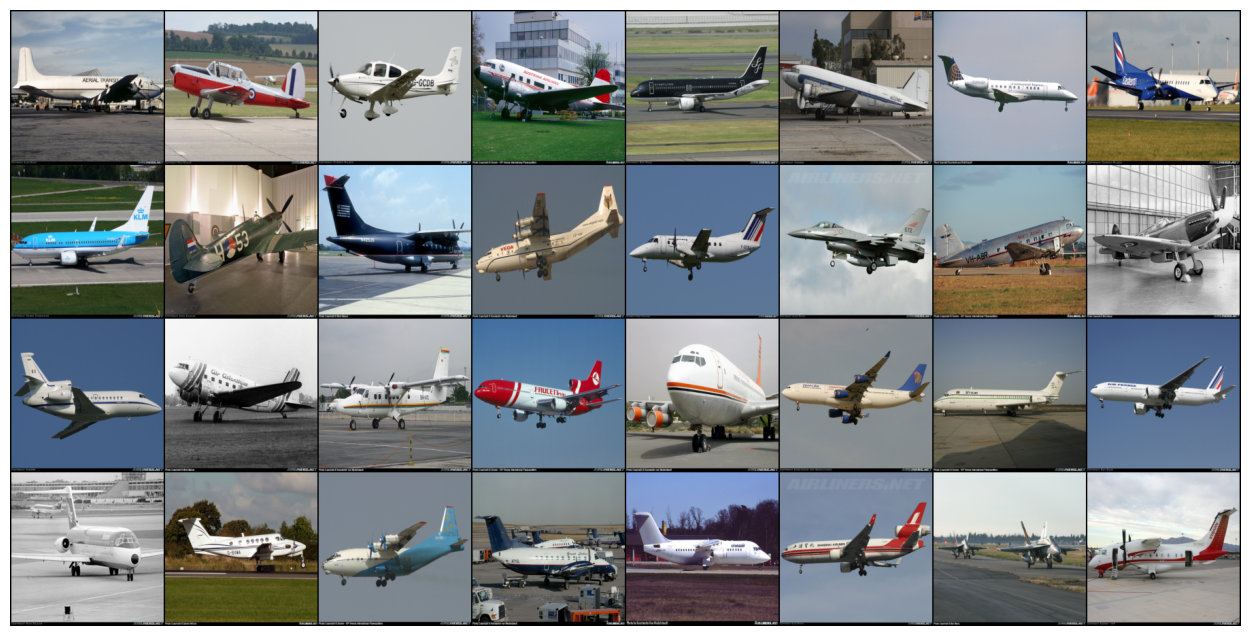

In [ ]:
from torchvision.utils import make_grid

for images, _ in train_loader:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break


In [ ]:
class ConvBlock(nn.Module):
  def __init__(self,in_channels,out_channels,kernel_size,**kwargs):
    super(ConvBlock,self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs)
    self.relu = nn.ReLU()
    self.batch_norm = nn.BatchNorm2d(out_channels)

  def forward(self,x):
    return self.relu(self.batch_norm(self.conv(x)))

In [ ]:
class InceptionBlock(nn.Module):
  def __init__(self,channels,num_1x1, num_3x3_reduce, num_3x3, num_5x5_reduce, num_5x5, pool_output):
    super(InceptionBlock,self).__init__()

    self.one_by_one = ConvBlock(channels,num_1x1,kernel_size=1)

    self.three_by_three_reduce = ConvBlock(channels,num_3x3_reduce,kernel_size=1)
    self.three_by_three = ConvBlock(num_3x3_reduce,num_3x3,kernel_size=3,padding=1)

    self.five_by_five_reduce = ConvBlock(channels,num_5x5_reduce,kernel_size=1)
    self.five_by_five = ConvBlock(num_5x5_reduce,num_5x5,kernel_size=5,padding=2)

    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    self.pool = ConvBlock(channels, pool_output, kernel_size=1)

  def forward(self,x):

    x1 = self.one_by_one(x)
    x2 = self.three_by_three(self.three_by_three_reduce(x))
    x3 =  self.five_by_five(self.five_by_five_reduce(x))
    x4 = self.pool(self.maxpool(x))
    out = torch.cat([x1,x2,x3,x4],1)

    return out

In [ ]:
class AuxiliaryOutput(nn.Module):
  def __init__(self,in_channels,num_classes):
    super(AuxiliaryOutput,self).__init__()
    self.avg_pool = nn.AvgPool2d(kernel_size=5,stride=3)
    self.conv = ConvBlock(in_channels,128,kernel_size=1)
    self.fully_connected_1 = nn.Linear(2048,1024)
    self.fully_connected_2 = nn.Linear(1024,num_classes)
    self.dropout = nn.Dropout(0.7)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax()

  def forward(self,x):
    out = self.avg_pool(x)
    out = self.conv(out)
    out = out.reshape(out.shape[0], -1)

    out = self.relu(self.fully_connected_1(out))
    out = self.dropout(out)
    out = self.fully_connected_2(out)

    return out


In [ ]:
class InceptionNet(nn.Module):
  def __init__(self,in_channels,num_classes,auxilary_output):
    super(InceptionNet,self).__init__()

    self.in_channels = in_channels
    self.num_classes = num_classes

    self.auxilary_output = auxilary_output
    self.conv1 = ConvBlock(in_channels,64,7,stride=2,padding=3)

    self.max_pool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
    self.conv2 = ConvBlock(64,192,kernel_size=3,stride=1,padding=1)

    self.dropout = nn.Dropout(0.4)
    self.fc = nn.Linear(1024,num_classes)

    self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)

    if self.auxilary_output:
      self.auxiliary4a = AuxiliaryOutput(512, num_classes)
      self.auxiliary4d = AuxiliaryOutput(528, num_classes)

    self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
    self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
    self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
    self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
    self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
    self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
    self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
    self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
    self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)

  def forward(self, x):
    y = None
    z = None

    x = self.conv1(x)
    x = self.max_pool(x)
    x = self.conv2(x)
    x = self.max_pool(x)

    x = self.inception3a(x)
    x = self.inception3b(x)
    x = self.max_pool(x)

    x = self.inception4a(x)
    if self.training and self.auxilary_output:
        y = self.auxiliary4a(x)

    x = self.inception4b(x)
    x = self.inception4c(x)
    x = self.inception4d(x)
    if self.training and self.auxilary_output:
        z = self.auxiliary4d(x)

    x = self.inception4e(x)
    x = self.max_pool(x)

    x = self.inception5a(x)
    x = self.inception5b(x)
    x = self.avgpool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.dropout(x)

    x = self.fc(x)

    return x, y, z

In [ ]:
inception_net = InceptionNet(3,num_classes,True)
inception_net.to(device)

InceptionNet(
  (conv1): ConvBlock(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (relu): ReLU()
    (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): ConvBlock(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (batch_norm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=1024, out_features=100, bias=True)
  (avgpool): AvgPool2d(kernel_size=7, stride=1, padding=0)
  (auxiliary4a): AuxiliaryOutput(
    (avg_pool): AvgPool2d(kernel_size=5, stride=3, padding=0)
    (conv): ConvBlock(
      (conv): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
      (relu): ReLU()
      (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_run

In [ ]:
from torchsummary import summary

summary(inception_net, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         ConvBlock-4         [-1, 64, 112, 112]               0
         MaxPool2d-5           [-1, 64, 56, 56]               0
            Conv2d-6          [-1, 192, 56, 56]         110,784
       BatchNorm2d-7          [-1, 192, 56, 56]             384
              ReLU-8          [-1, 192, 56, 56]               0
         ConvBlock-9          [-1, 192, 56, 56]               0
        MaxPool2d-10          [-1, 192, 28, 28]               0
           Conv2d-11           [-1, 64, 28, 28]          12,352
      BatchNorm2d-12           [-1, 64, 28, 28]             128
             ReLU-13           [-1, 64, 28, 28]               0
        ConvBlock-14           [-1, 64,

In [ ]:
criterion = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.Adam(params=inception_net.parameters(), lr=0.0001)


In [ ]:
%%time
from  tqdm import tqdm

torch.cuda.empty_cache()
epoch = 10

running_losses = []

for e in range(epoch):
    running_loss = 0.0
    train_acc = 0.0
    val_acc = 0.0

    inception_net.train()
    corr = 0
    test_loss, test_acc = 0, 0

    tqdm_stream_train = tqdm(train_loader)
    tqdm_stream_test = tqdm(test_loader)

    for i, d in enumerate(tqdm_stream_train):
        X_batched = d[0]
        y_batched = d[1] #type(torch.float32)

        X_batched = X_batched.to(device) #cuda()
        y_batched = y_batched.to(device) # (N,), torch.int64

        optimizer.zero_grad()
        outputs, aux1, aux2 = inception_net(X_batched)
        loss = criterion(outputs, y_batched) + 0.3 * criterion(aux1, y_batched) + 0.3 * criterion(aux2, y_batched)
        _, preds = torch.max(outputs, 1)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        corr += torch.sum(preds == y_batched.data)


        tqdm_stream_train.set_description(f"Trainning Epoch{e+1:3d}")



    running_loss = running_loss / len(train_loader)
    running_losses.append(running_loss)
    train_acc = corr / len(train_data)

    print(f"RESULT Epoch{e+1:3d}, Train Loss:{running_loss:.6f}, Train Acc.:{train_acc:.6f}") #, Valid Acc.:{val_acc:.6f}")


  0%|          | 0/209 [00:00<?, ?it/s]

Trainning Epoch  1: 100%|██████████| 209/209 [02:17<00:00,  1.51it/s]


RESULT Epoch  1, Train Loss:6.439610, Train Acc.:0.090295


Trainning Epoch  2: 100%|██████████| 209/209 [02:14<00:00,  1.55it/s]


RESULT Epoch  2, Train Loss:5.626160, Train Acc.:0.154642


  0%|          | 0/209 [00:00<?, ?it/s]

Trainning Epoch  3: 100%|██████████| 209/209 [02:15<00:00,  1.54it/s]


RESULT Epoch  3, Train Loss:4.851184, Train Acc.:0.251837


Trainning Epoch  4: 100%|██████████| 209/209 [02:14<00:00,  1.55it/s]


RESULT Epoch  4, Train Loss:4.228569, Train Acc.:0.321584


  0%|          | 0/209 [00:00<?, ?it/s]

Trainning Epoch  5: 100%|██████████| 209/209 [02:13<00:00,  1.56it/s]


RESULT Epoch  5, Train Loss:3.668165, Train Acc.:0.404680


Trainning Epoch  6: 100%|██████████| 209/209 [02:17<00:00,  1.52it/s]


RESULT Epoch  6, Train Loss:3.159423, Train Acc.:0.494975


  0%|          | 0/209 [00:00<?, ?it/s]

Trainning Epoch  7: 100%|██████████| 209/209 [02:14<00:00,  1.55it/s]


RESULT Epoch  7, Train Loss:2.705694, Train Acc.:0.569821


Trainning Epoch  8: 100%|██████████| 209/209 [02:17<00:00,  1.52it/s]


RESULT Epoch  8, Train Loss:2.250642, Train Acc.:0.644668


  0%|          | 0/209 [00:00<?, ?it/s]

Trainning Epoch  9: 100%|██████████| 209/209 [02:14<00:00,  1.55it/s]


RESULT Epoch  9, Train Loss:1.903164, Train Acc.:0.711414


Trainning Epoch 10: 100%|██████████| 209/209 [02:16<00:00,  1.53it/s]

RESULT Epoch 10, Train Loss:1.572226, Train Acc.:0.772011
CPU times: user 2min 32s, sys: 15.5 s, total: 2min 47s
Wall time: 22min 36s


In [ ]:
tqdm_stream_check_val = tqdm(test_loader)
corr = 0

for j, d in enumerate(tqdm_stream_check_val):
    inception_net.eval()
    X_batched = d[0]
    y_batched = d[1]

    X_batched = X_batched.to(device) #cuda()
    y_batched = y_batched.to(device) #cuda()

    outputs, aux1, aux2 = inception_net(X_batched)
    _, preds = torch.max(outputs, 1)
    corr += torch.sum(preds == y_batched.data)

    tqdm_stream_check_val.set_description("Acc. for TEST SET")


  0%|          | 0/105 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Acc. for TEST SET: 100%|██████████| 105/105 [01:08<00:00,  1.52it/s]


In [ ]:
test_acc = corr / len(test_data)
test_acc


tensor(0.3801, device='cuda:0')

In [ ]:
CLASSES = train_data.classes

In [ ]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit[0].squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [ ]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({CLASSES[test_labels[0]]})")


Test sample image shape: torch.Size([3, 224, 224])
Test sample label: 78 (Fokker 70)


In [ ]:
pred_probs= make_predictions(model=inception_net,
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]


tensor([[2.4653e-05, 4.8031e-04, 3.0038e-03, 1.1843e-03, 1.5828e-03, 9.0983e-03,
         6.7835e-04, 3.8098e-03, 2.2122e-03, 6.0525e-04, 2.4752e-05, 6.3909e-05,
         1.1422e-04, 1.8994e-04, 7.2511e-04, 3.5394e-05, 3.6602e-04, 2.4000e-04,
         2.0471e-05, 1.1407e-04, 2.5661e-05, 4.5754e-04, 1.1754e-03, 1.2511e-03,
         4.3303e-03, 1.6694e-02, 1.9841e-03, 1.2556e-03, 1.5487e-04, 7.1806e-05,
         1.0516e-04, 4.7147e-05, 9.5213e-06, 6.7658e-05, 1.1431e-04, 2.7263e-05,
         9.7141e-05, 1.8826e-04, 1.9273e-04, 3.7953e-04, 2.3399e-04, 4.3425e-03,
         1.5936e-05, 1.5420e-04, 1.3041e-03, 5.6083e-04, 2.4225e-04, 1.1967e-04,
         3.0037e-04, 2.2348e-03, 2.8121e-04, 8.5850e-04, 8.9652e-05, 1.1999e-04,
         3.2886e-05, 8.8658e-05, 2.3054e-03, 6.1300e-05, 3.7766e-04, 5.8454e-05,
         1.4186e-04, 5.4300e-05, 9.9442e-04, 2.6114e-04, 1.3248e-02, 1.1794e-02,
         5.8290e-04, 1.6101e-03, 1.2640e-02, 1.0404e-02, 6.6085e-04, 2.4189e-05,
         1.9697e-05, 5.0311e

In [ ]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes


tensor([78,  7,  4,  5, 85, 21, 21, 85, 90])

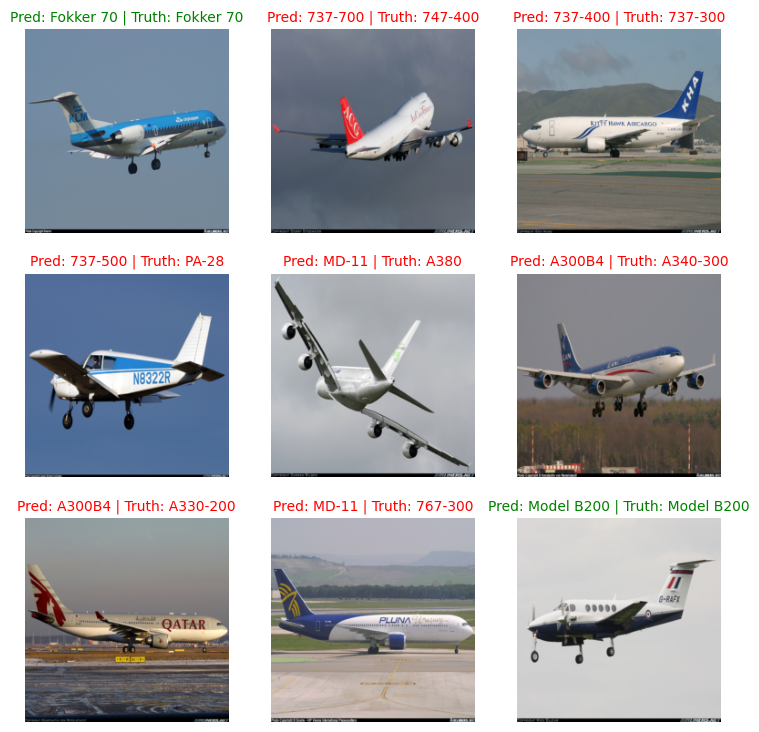

In [ ]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.permute(1,2,0), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = CLASSES[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = CLASSES[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);
